In [1]:
%load_ext autoreload
%autoreload 2

import utilities
from evaluator import Evaluator
from embedder import Embedder
from embedder import Transformer
from embedder import Transformer_GNN
from embedder import Transformer_GNN_embedder
from embedder import Preprocessing_scaler
from Graph_generator import Graph_Generator
import tmp_generator as tmp
from visualizator import Visualizator

from eden import graph
import umap 

import numpy as np
from sklearn.decomposition import TruncatedSVD

Using TensorFlow backend.


# Generate graphs + LDP

In [51]:
n_graphs = 2000

# 20 permutations
gg = Graph_Generator(n_graphs=n_graphs,
                     degree = 4)
g1, na1, ea1 = gg.generate(20,10,10,1)
g2, na2, ea2 = gg.generate(20,10,10,10)

graphs, labels = gg.generate_set(g1,g2,na1, ea1,na2, ea2,15,15,plot=False)

functions = [utilities.degree,utilities.clust_coefficient,utilities.local_degree_profile]
graphs = utilities.add_info_to_nodes(graphs,functions)


max_n_nodes, n_attributes = utilities.find_shapes(graphs)
n_classes = len(np.unique(labels))

print("done")

done


In [52]:
def tmp_preprocessing_vectorize(graphs):        

    for g in graphs:
        
        c=0
        for n in g.nodes():
            a = g.nodes[n]['vec']
            del g.nodes[n]['vec']
            g.nodes[n]['label'] = str(a[0])
            g.nodes[n]['vec'] = a
            c=c+1

    for g in graphs:
        c=0
        for n in g.edges():
            a = g.edges[n]['vec']
            del g.edges[n]['vec']      
            g.edges[n]['label'] = str(a[0])
            g.edges[n]['vec'] = a[0]
            c=c+1

    return(graphs)

graphs = tmp_preprocessing_vectorize(graphs)

In [53]:
# setting 

dim = [2,3,5]
times = 1


batch_size = 32
validation_split = 0.2
epochs_GNN = 100
epochs_autoencoder = 200
verbose=0
plot=False

## Embedder 1
### Spektral + PCA

In [54]:
my_GNN = tmp.generate_GNN(max_n_nodes,
                      n_attributes,
                      n_classes,
                      batch_size = batch_size,
                      validation_split = validation_split,
                      epochs = epochs_GNN,
                      verbose = verbose, 
                      plot=plot)

m_1 = Transformer(my_GNN)
m_2 = Transformer(TruncatedSVD())
emb_1 = Embedder([m_1,m_2],"Spektral + PCA")

## Embedder 2
### Spektral + Small 128 - n_components

In [55]:
my_GNN_small = tmp.gen_gnn_small(max_n_nodes,
                                 n_attributes,
                                 batch_size = batch_size,
                                 validation_split = validation_split,
                                 epochs = epochs_GNN,
                                 dim = dim,
                                 plot = plot)

m_1 = Transformer(my_GNN_small)
emb_2 = Embedder([m_1],"Spektral + small")

## Embedder 3
### Spektral + Dense 128 - 64 - 32 - 16 -  8 - n_components

In [56]:
my_GNN_dense = tmp.gen_gnn_dense(max_n_nodes,
                                 n_attributes,
                                 batch_size = batch_size,
                                 validation_split = validation_split,
                                 epochs = epochs_GNN,
                                 dim = dim,
                                 plot = plot)

m_1 = Transformer(my_GNN_dense)
emb_3 = Embedder([m_1],"Spektral + dense")

## Embedder 4
### Spektral fino a 128 + Autoencoder 128 - 64- 16 - 8 - 5 - 3 - 2
### Preprocessing_scaler -0.5 ; 0.5

In [57]:
# modello 1 GNN
my_GNN = tmp.generate_GNN(max_n_nodes,n_attributes,n_classes,
                           batch_size=batch_size,
                           validation_split=validation_split,
                           verbose=verbose,
                           epochs=epochs_GNN,
                           plot=plot)
m_1 = Transformer(my_GNN)

# preprocessing scaler
my_scaler = Preprocessing_scaler([-0.5, 0.5])
# modello 2 Autoencoder
my_Autoencoder = tmp.gen_transf_autoencoder(batch_size=batch_size,
                                            validation_split=validation_split,
                                            epochs=epochs_autoencoder, 
                                            verbose=verbose,
                                            scaler=my_scaler,
                                            dim = dim,
                                            plot=plot)

m_2 = Transformer(my_Autoencoder)


emb_4 = Embedder([m_1,m_2], name="Spketral 128 - Autoencoder denso")

## Embedder 5
### Vectorize + pca 1000 + umap

In [58]:
vetcoriz = graph.Vectorizer(complexity = 5)
m_1= Transformer(vetcoriz, has_fit = False)
pca = TruncatedSVD(n_components=1000)
m_2 = Transformer(pca)
uma = umap.UMAP()
m_3 = Transformer(uma)

emb_5 = Embedder([m_1,m_2,m_3], name="Vectorize-5, PCA-1000, UMAP")

In [66]:
print("\t 500 grafi")
vis_500_compx15.summary(std = False)
vis_500_compx15.summary()
print("\n \n RANK")
vis_500_compx15.rank()

print("\n \n \n")
print("\t 800 grafi")
vis_800_compx15.summary(std = False)
vis_800_compx15.summary()
print("\n \n RANK")
vis_500_compx15.rank()

print("\n \n \n")
print("\t 1000 grafi")
vis_1000_compx15.summary(std = False)
vis_1000_compx15.summary()
print("\n \n RANK")
vis_1000_compx15.rank()

print("\n \n \n")
print("\t 2000 grafi")
vis_2000_compx15.summary(std = False)
vis_2000_compx15.summary()
print("\n \n RANK")
vis_2000_compx15.rank()


	 500 grafi
                                      2      3      5    mean
--------------------------------  -----  -----  -----  ------
Spektral + PCA                    0.747  0.754  0.758   0.753
Spektral + small                  0.77   0.647  0.762   0.726
Spektral + dense                  0.567  0.737  0.742   0.682
Spketral 128 - Autoencoder denso  0.613  0.597  0.645   0.618
Vectorize-5, PCA-1000, UMAP       0.781  0.785  0.798   0.788
                                      2    STD      3    STD      5    STD    mean
--------------------------------  -----  -----  -----  -----  -----  -----  ------
Spektral + PCA                    0.747  0.111  0.754  0.108  0.758  0.117   0.433
Spektral + small                  0.77   0.108  0.647  0.143  0.762  0.084   0.419
Spektral + dense                  0.567  0.117  0.737  0.101  0.742  0.09    0.392
Spketral 128 - Autoencoder denso  0.613  0.128  0.597  0.119  0.645  0.116   0.37
Vectorize-5, PCA-1000, UMAP       0.781  0.091  0.785  0.

In [154]:
print("\t 500 grafi")
vis_500_compx15.summary()
print("\n \n \n")
print("\t 800 grafi")
vis_800_compx15.summary()
print("\n \n \n")
print("\t 1000 grafi")
vis_1000_compx15.summary()
print("\n \n \n")
print("\t 2000 grafi")
vis_2000_compx15.summary()

	 500 grafi
                                      2    STD      3    STD      5    STD    mean
--------------------------------  -----  -----  -----  -----  -----  -----  ------
Spektral + PCA                    0.747  0.111  0.754  0.108  0.758  0.117   0.433
Spektral + small                  0.77   0.108  0.647  0.143  0.762  0.084   0.419
Spektral + dense                  0.567  0.117  0.737  0.101  0.742  0.09    0.392
Spketral 128 - Autoencoder denso  0.613  0.128  0.597  0.119  0.645  0.116   0.37
Vectorize-5, PCA-1000, UMAP       0.781  0.091  0.785  0.093  0.798  0.13    0.446

 
 

	 800 grafi
                                      2    STD      3    STD      5    STD    mean
--------------------------------  -----  -----  -----  -----  -----  -----  ------
Spektral + PCA                    0.676  0.074  0.723  0.089  0.727  0.086   0.396
Spektral + small                  0.641  0.1    0.72   0.076  0.745  0.093   0.396
Spektral + dense                  0.72   0.07   0.724  0.0

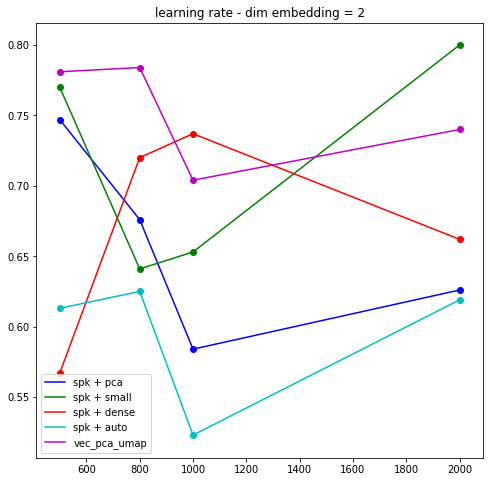

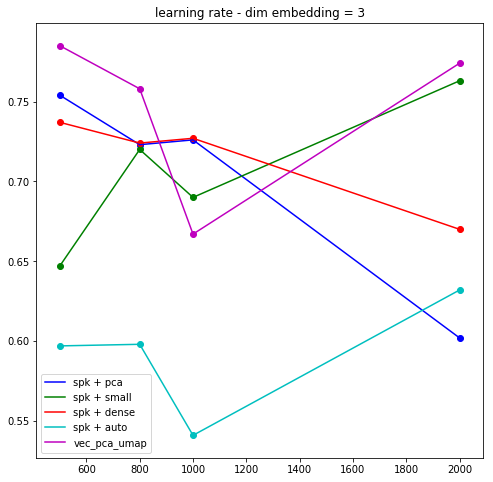

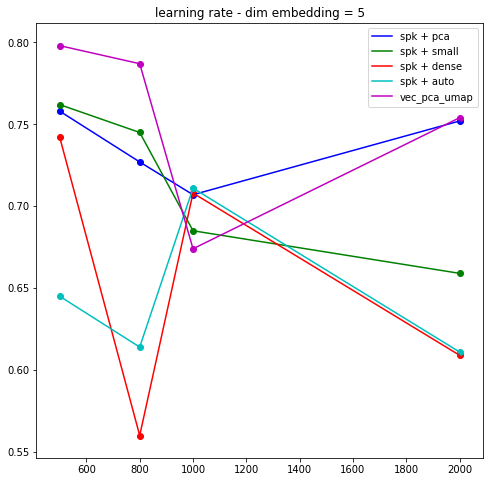

In [156]:
visualizators = [vis_500_compx15, vis_800_compx15,vis_1000_compx15,vis_2000_compx15]

temp_plot(visualizators, 2)
temp_plot(visualizators, 3)
temp_plot(visualizators, 5)

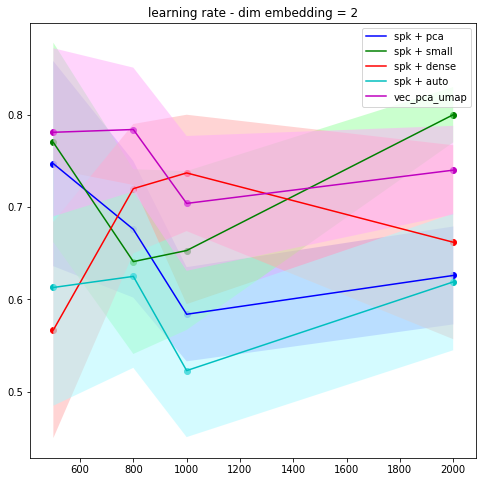

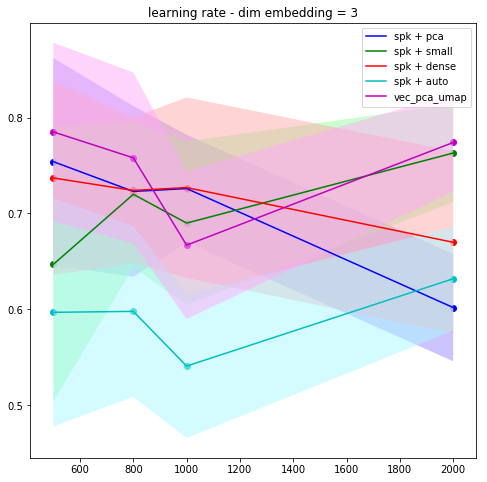

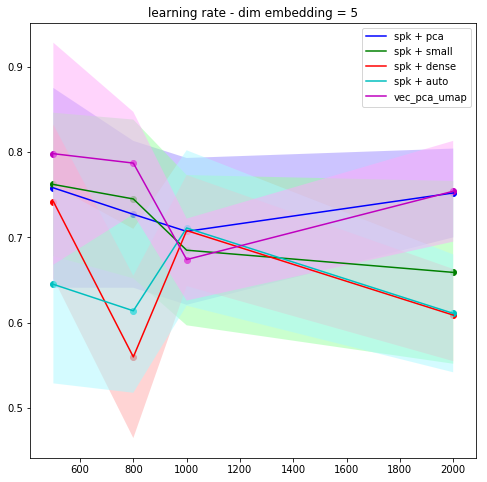

In [157]:
tmp_plot_std(visualizators, 2)
tmp_plot_std(visualizators, 3)
tmp_plot_std(visualizators, 5)

In [119]:


import matplotlib.pyplot as plt
def temp_plot(visualizators,dim_embedding):
    pos = 1
    if (dim_embedding == 2):
        pos = 1
    if (dim_embedding == 3):
        pos = 2
    if (dim_embedding == 5):
        pos = 3

    spk_pca = []
    spk_small = []
    spk_dense = []
    spk_auto = []
    vect_pca_umap = []

    for v in visualizators:
        result_matrix = v.summary(std=False,return_matrix=True)

        spk_pca.append(result_matrix[0][pos])
        spk_small.append(result_matrix[1][pos])
        spk_dense.append(result_matrix[2][pos])
        spk_auto.append(result_matrix[3][pos])
        vect_pca_umap.append(result_matrix[4][pos])

    a = [500,800,1000,2000]
    plt.figure(figsize=(8,8))
    plt.title(str("learning rate - dim embedding = "+str(dim_embedding)))
    plt.plot(a,spk_pca, label='spk + pca',color='b')
    plt.scatter(a,spk_pca,color='b')
    plt.plot(a,spk_small, label='spk + small',color='g')
    plt.scatter(a,spk_small,color='g')
    plt.plot(a,spk_dense, label='spk + dense',color='r')
    plt.scatter(a,spk_dense,color='r')
    plt.plot(a,spk_auto, label='spk + auto',color='c')
    plt.scatter(a,spk_auto,color='c')
    plt.plot(a,vect_pca_umap, label='vec_pca_umap',color='m')
    plt.scatter(a,vect_pca_umap,color='m')
    plt.legend()

In [151]:


def tmp_plot_std(visualizators,dim_embedding):
    if (dim_embedding == 2):
        pos = 1
    if (dim_embedding == 3):
        pos = 3
    if (dim_embedding == 5):
        pos = 5



    spk_pca = []
    spk_pca_std = []
    spk_small = []
    spk_small_std = []
    spk_dense = []
    spk_dense_std = []
    spk_auto = []
    spk_auto_std = []
    vect_pca_umap = []
    vect_pca_umap_std = []

    for v in visualizators:
        result_matrix = v.summary(return_matrix=True)

        spk_pca.append(result_matrix[0][pos])
        spk_pca_std.append(result_matrix[0][pos+1])
        spk_small.append(result_matrix[1][pos])
        spk_small_std.append(result_matrix[1][pos+1])
        spk_dense.append(result_matrix[2][pos])
        spk_dense_std.append(result_matrix[2][pos+1])
        spk_auto.append(result_matrix[3][pos])
        spk_auto_std.append(result_matrix[3][pos+1])
        vect_pca_umap.append(result_matrix[4][pos])
        vect_pca_umap_std.append(result_matrix[4][pos+1])


    a = [500,800,1000,2000]
    plt.figure(figsize=(8,8))
    plt.title(str("learning rate - dim embedding = "+str(dim_embedding)))
    plt.plot(a,spk_pca, label='spk + pca',color='b')
    plt.scatter(a,spk_pca,color='b')
    low = [spk_pca[i]-spk_pca_std[i] for i in range(0,len(spk_pca))]
    upp = [spk_pca[i]+spk_pca_std[i] for i in range(0,len(spk_pca))]
    plt.fill_between(a, low,upp, facecolor='#9B8BFF', alpha=0.5)

    plt.plot(a,spk_small, label='spk + small',color='g')
    plt.scatter(a,spk_small,color='g')
    low = [spk_small[i]-spk_small_std[i] for i in range(0,len(spk_small))]
    upp = [spk_small[i]+spk_small_std[i] for i in range(0,len(spk_small))]
    plt.fill_between(a, low,upp, facecolor='#97ff9f', alpha=0.5)

    plt.plot(a,spk_dense, label='spk + dense',color='r')
    plt.scatter(a,spk_dense,color='r')
    low = [spk_dense[i]-spk_dense_std[i] for i in range(0,len(spk_small))]
    upp = [spk_dense[i]+spk_dense_std[i] for i in range(0,len(spk_small))]
    plt.fill_between(a, low,upp, facecolor='#ffaaaa', alpha=0.5)

    plt.plot(a,spk_auto, label='spk + auto',color='c')
    plt.scatter(a,spk_auto,color='c')
    low = [spk_auto[i]-spk_auto_std[i] for i in range(0,len(spk_small))]
    upp = [spk_auto[i]+spk_auto_std[i] for i in range(0,len(spk_small))]
    plt.fill_between(a, low,upp, facecolor='#aaf9ff', alpha=0.5)
    vect_pca_umap_std

    plt.plot(a,vect_pca_umap, label='vec_pca_umap',color='m')
    plt.scatter(a,vect_pca_umap,color='m')
    low = [vect_pca_umap[i]-vect_pca_umap_std[i] for i in range(0,len(spk_small))]
    upp = [vect_pca_umap[i]+vect_pca_umap_std[i] for i in range(0,len(spk_small))]
    plt.fill_between(a, low,upp, facecolor='#ffaafb', alpha=0.5)


    plt.legend()

# Experiments

In [59]:
times = 3

In [60]:
vis_2000_compx15 = utilities.repeat_n_times(graphs, labels, [emb_1,emb_2,emb_3,emb_4,emb_5], [2,3,5], times,test_size=0.3,seed = 11)
# 14:39

	 iteration n: 1
	 	 dim:  2
	 	 	  Spektral + PCA
0
	 	 	  Spektral + small
0
	 	 	  Spektral + dense
85
	 	 	  Spketral 128 - Autoencoder denso
0
	 	 	  Vectorize-5, PCA-1000, UMAP
	 	 dim:  3
	 	 	  Spektral + PCA
0
	 	 	  Spektral + small
0
	 	 	  Spektral + dense
0
	 	 	  Spketral 128 - Autoencoder denso
0
	 	 	  Vectorize-5, PCA-1000, UMAP
	 	 dim:  5
	 	 	  Spektral + PCA
0
	 	 	  Spektral + small
0
	 	 	  Spektral + dense
0
	 	 	  Spketral 128 - Autoencoder denso
0
	 	 	  Vectorize-5, PCA-1000, UMAP
	 iteration n: 2
	 	 dim:  2
	 	 	  Spektral + PCA
0
	 	 	  Spektral + small
93
	 	 	  Spektral + dense
0
	 	 	  Spketral 128 - Autoencoder denso
0
	 	 	  Vectorize-5, PCA-1000, UMAP
	 	 dim:  3
	 	 	  Spektral + PCA
0
	 	 	  Spektral + small
0
	 	 	  Spektral + dense
0
	 	 	  Spketral 128 - Autoencoder denso
0
	 	 	  Vectorize-5, PCA-1000, UMAP
	 	 dim:  5
	 	 	  Spektral + PCA
0
	 	 	  Spektral + small
0
	 	 	  Spektral + dense
0
	 	 	  Spketral 128 - Autoencoder denso
0
	 	 	  Ve

In [49]:
vis_800_compx15 = utilities.repeat_n_times(graphs, labels, [emb_1,emb_2,emb_3,emb_4,emb_5], [2,3,5], times,test_size=0.3,seed = 11)
# 14:24
# 14:37

	 iteration n: 1
	 	 dim:  2
	 	 	  Spektral + PCA
0
	 	 	  Spektral + small
0
	 	 	  Spektral + dense
0
	 	 	  Spketral 128 - Autoencoder denso
72
	 	 	  Vectorize-5, PCA-1000, UMAP
	 	 dim:  3
	 	 	  Spektral + PCA
0
	 	 	  Spektral + small
0
	 	 	  Spektral + dense
0
	 	 	  Spketral 128 - Autoencoder denso
0
	 	 	  Vectorize-5, PCA-1000, UMAP
	 	 dim:  5
	 	 	  Spektral + PCA
0
	 	 	  Spektral + small
0
	 	 	  Spektral + dense
0
	 	 	  Spketral 128 - Autoencoder denso
51
	 	 	  Vectorize-5, PCA-1000, UMAP
	 iteration n: 2
	 	 dim:  2
	 	 	  Spektral + PCA
0
	 	 	  Spektral + small
0
	 	 	  Spektral + dense
0
	 	 	  Spketral 128 - Autoencoder denso
0
	 	 	  Vectorize-5, PCA-1000, UMAP
	 	 dim:  3
	 	 	  Spektral + PCA
0
	 	 	  Spektral + small
0
	 	 	  Spektral + dense
0
	 	 	  Spketral 128 - Autoencoder denso
0
	 	 	  Vectorize-5, PCA-1000, UMAP
	 	 dim:  5
	 	 	  Spektral + PCA
0
	 	 	  Spektral + small
0
	 	 	  Spektral + dense
0
	 	 	  Spketral 128 - Autoencoder denso
0
	 	 	  Ve

In [27]:
vis_500_compx15 = utilities.repeat_n_times(graphs, labels, [emb_1,emb_2,emb_3,emb_4,emb_5], [2,3,5], times,test_size=0.3,seed = 11)
# 12.31

	 iteration n: 1
	 	 dim:  2
	 	 	  Spektral + PCA
0
	 	 	  Spektral + small
0
	 	 	  Spektral + dense
0
	 	 	  Spketral 128 - Autoencoder denso
0
	 	 	  Vectorize-5, PCA-1000, UMAP
	 	 dim:  3
	 	 	  Spektral + PCA
0
	 	 	  Spektral + small
0
	 	 	  Spektral + dense
0
	 	 	  Spketral 128 - Autoencoder denso
0
	 	 	  Vectorize-5, PCA-1000, UMAP
	 	 dim:  5
	 	 	  Spektral + PCA
56
	 	 	  Spektral + small
0
	 	 	  Spektral + dense
0
	 	 	  Spketral 128 - Autoencoder denso
0
	 	 	  Vectorize-5, PCA-1000, UMAP
	 iteration n: 2
	 	 dim:  2
	 	 	  Spektral + PCA
48
	 	 	  Spektral + small
0
	 	 	  Spektral + dense
0
	 	 	  Spketral 128 - Autoencoder denso
0
	 	 	  Vectorize-5, PCA-1000, UMAP
	 	 dim:  3
	 	 	  Spektral + PCA
78
	 	 	  Spektral + small
0
	 	 	  Spektral + dense
0
	 	 	  Spketral 128 - Autoencoder denso
0
	 	 	  Vectorize-5, PCA-1000, UMAP
	 	 dim:  5
	 	 	  Spektral + PCA
0
	 	 	  Spektral + small
0
	 	 	  Spektral + dense
0
	 	 	  Spketral 128 - Autoencoder denso
0
	 	 	  V

In [61]:
print("\t 500 grafi")
vis_500_compx15.summary(std = False)
vis_500_compx15.summary()
print("\n \n RANK")
vis_500_compx15.rank()

print("\n \n \n")
print("\t 800 grafi")
vis_800_compx15.summary(std = False)
vis_800_compx15.summary()
print("\n \n RANK")
vis_500_compx15.rank()

print("\n \n \n")
print("\t 1000 grafi")
vis_1000_compx15.summary(std = False)
vis_1000_compx15.summary()
print("\n \n RANK")
vis_1000_compx15.rank()

print("\n \n \n")
print("\t 2000 grafi")
vis_2000_compx15.summary(std = False)
vis_2000_compx15.summary()
print("\n \n RANK")
vis_2000_compx15.rank()


	 500 grafi
                                      2      3      5    mean
--------------------------------  -----  -----  -----  ------
Spektral + PCA                    0.747  0.754  0.758   0.753
Spektral + small                  0.77   0.647  0.762   0.726
Spektral + dense                  0.567  0.737  0.742   0.682
Spketral 128 - Autoencoder denso  0.613  0.597  0.645   0.618
Vectorize-5, PCA-1000, UMAP       0.781  0.785  0.798   0.788
                                      2    STD      3    STD      5    STD    mean
--------------------------------  -----  -----  -----  -----  -----  -----  ------
Spektral + PCA                    0.747  0.111  0.754  0.108  0.758  0.117   0.433
Spektral + small                  0.77   0.108  0.647  0.143  0.762  0.084   0.419
Spektral + dense                  0.567  0.117  0.737  0.101  0.742  0.09    0.392
Spketral 128 - Autoencoder denso  0.613  0.128  0.597  0.119  0.645  0.116   0.37
Vectorize-5, PCA-1000, UMAP       0.781  0.091  0.785  0.

In [62]:
print("\t 500 grafi")
vis_500_compx15.rank()

print("\n \n \n")
vis_500_compx15.rank()

print("\n \n \n")
vis_1000_compx15.rank()

print("\n \n \n")
vis_2000_compx15.rank()


	 500 grafi
                                    2    3    5     mean
--------------------------------  ---  ---  ---  -------
Spektral + PCA                      3    2    3  2.66667
Spektral + small                    2    4    2  2.66667
Spektral + dense                    5    3    4  4
Spketral 128 - Autoencoder denso    4    5    5  4.66667
Vectorize-5, PCA-1000, UMAP         1    1    1  1

 
 

                                    2    3    5     mean
--------------------------------  ---  ---  ---  -------
Spektral + PCA                      3    2    3  2.66667
Spektral + small                    2    4    2  2.66667
Spektral + dense                    5    3    4  4
Spketral 128 - Autoencoder denso    4    5    5  4.66667
Vectorize-5, PCA-1000, UMAP         1    1    1  1

 
 

                                    2    3    5     mean
--------------------------------  ---  ---  ---  -------
Spektral + PCA                      4    2    3  3
Spektral + small                    3